In [19]:
FN = 'vocabulary-embedding'

In [20]:
seed=42

In [21]:
vocab_size = 40000

In [22]:
embedding_dim = 100

In [23]:
lower = False # dont lower case the text

In [24]:
import pickle
FN0 = 'tokens' # this is the name of the data file which I assume you already have
with open('%s.pkl'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [25]:
if lower:
    heads = [h.lower() for h in heads]


In [26]:
if lower:
    desc = [h.lower() for h in desc]

In [27]:
i=0
heads[i]


'Worcester breakfast club for veterans gives hunger its marching orders'

In [28]:
desc[i]

'VETERANS saluted Worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies.  The Worcester Breakfast Club for HM Forces Veterans met at the Postal Order in Foregate Street at 10am on Saturday.  The club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders.  Father-of-two Dave Carney, aged 43, of Merrimans Hill, Worcester, set up the club after being inspired by other similar clubs across the country.  He said: "As you can see from the picture, we had a good response. Five out of the 10 that attended said they saw the article in the newspaper and turned up.  "We even had an old chap travel from Droitwich and he was late on parade by three hours.  "It\'s generated a lot of interest and I estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. Onwards and upwards."  He said the management at the pub had been extremely hospitable 

In [29]:
keywords[i]

In [30]:
len(heads),len(set(heads))

(1000000, 802153)

# Build Vocabulary


In [31]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [32]:
vocab, vocabcount = get_vocab(heads+desc)

In [33]:
print(vocab[0:50])
print('...',len(vocab))

['the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'with', 'The', 'at', 'as', 'was', 'be', 'are', 'by', 'from', 'have', 'has', 'it', 'will', 'I', 'this', 'an', 'or', 'you', 'not', 'his', 'he', 'their', 'more', 'but', 'said', '-', 'they', 'who', 'we', 'can', 'which', 'its', 'been', 'about', 'all', 'had', 'also', 'our', 'were', 'one']
... 6723716


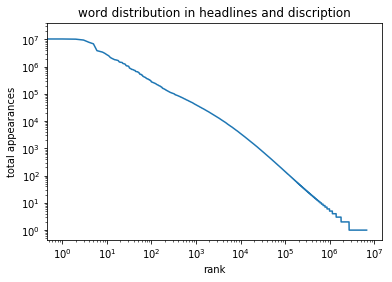

In [34]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');


In [35]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word


In [36]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [37]:

word2idx, idx2word = get_idx(vocab, vocabcount)

In [38]:
# # Word Embedding

# ## read GloVe
from keras.utils.data_utils import get_file
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    get_ipython().system('unzip {datadir}/{path}')

Using TensorFlow backend.


In [40]:
glove_n_symbols = get_ipython().getoutput('wc -l {glove_name}')
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols


OSError: [Errno 12] Cannot allocate memory

In [ ]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale


In [ ]:
glove_embedding_weights.std()


In [ ]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i


In [ ]:
# Use Glove to initialize embedding matrix

np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

In [ ]:
# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))


In [ ]:
glove_thr = 0.5

In [ ]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [ ]:

# for every word outside the embedding matrix find the closest word inside the mebedding matrix.
# Use cos distance of GloVe vectors.
# 
# Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
# Dont accept distances below `glove_thr`

normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

In [ ]:
# manually check that the worst substitutions we are going to do are good enough

for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])
    
    


In [ ]:

# build a lookup table of index of outside words to index of inside words
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

In [ ]:
# Data
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

In [ ]:
plt.hist(list(map(len,Y)),bins=50);


In [ ]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

In [ ]:
plt.hist(list(map(len,X)),bins=50);

In [ ]:
with open('%s.pkl'%FN,'wb+') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)


In [ ]:
with open('%s.data.pkl'%FN,'wb+') as fp:
    pickle.dump((X,Y),fp,-1)